# Performance

In [1]:
import bdms
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Runtime

Runtime analysis of a two-state process run for 4 simulation time units with 1000 different seeds.
For each seed we record the median of 5 repeated runtimes, as well as the number of nodes in the simulated tree.


In [2]:
birth = bdms.poisson.DiscreteProcess([0.1, 1.0])
mutation = bdms.poisson.ConstantProcess(1.0)
mutator = bdms.mutators.DiscreteMutator((0, 1), np.array([[0, 1], [1, 0]]))

In [3]:
runtimes = []
n_nodes = []

for seed in range(1000):
    repeats = []
    for _ in range(5):
        tree = bdms.Tree(state=0)
        runtime = time.time()
        tree.evolve(
            4.0,
            birth_process=birth,
            mutation_process=mutation,
            mutator=mutator,
            seed=seed,
        )
        repeats.append(time.time() - runtime)
    runtimes.append(np.median(repeats))
    n_nodes.append(sum(1 for node in tree.traverse()))

Plotting the runtime against the number of nodes in the tree, we see that the runtime scales linearly with the number of nodes in the tree.

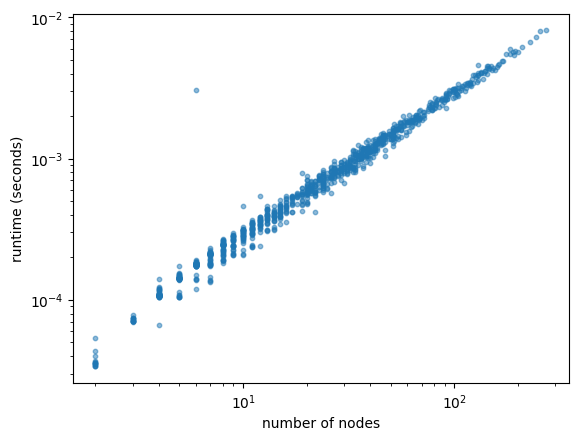

In [4]:
plt.scatter(n_nodes, runtimes, s=10, alpha=0.5)
plt.xlabel("number of nodes")
plt.ylabel("runtime (seconds)")
plt.xscale("log")
plt.yscale("log")
plt.show()

## Growth rate

To assess how population size grows with time, we'll perform 1000 simulations with 1000 different seeds for each of several simulation times.

In [5]:
sim_times = [1, 2, 3, 4]

In [6]:
rng = np.random.default_rng(0)
dat = []

for i, sim_time in enumerate(sim_times):
    for _ in range(1000):
        tree = bdms.Tree()
        try:
            tree.evolve(sim_time, seed=rng)
        finally:
            dat.append([sim_time, len(tree)])

df = pd.DataFrame(dat, columns=["time", "population size"])

For a Yule process with unit per-particle birth rate (our default simulation), the population size at time $t$ is a geometric random variable with parameter $p=e^{-t}$.
The plot below shows the empirical cumulative distribution function of population sizes at time $t$ for $t=1,2,3,4$, along with the theoretical cumulative distribution function of a geometric random variable with parameter $p=e^{-t}$.

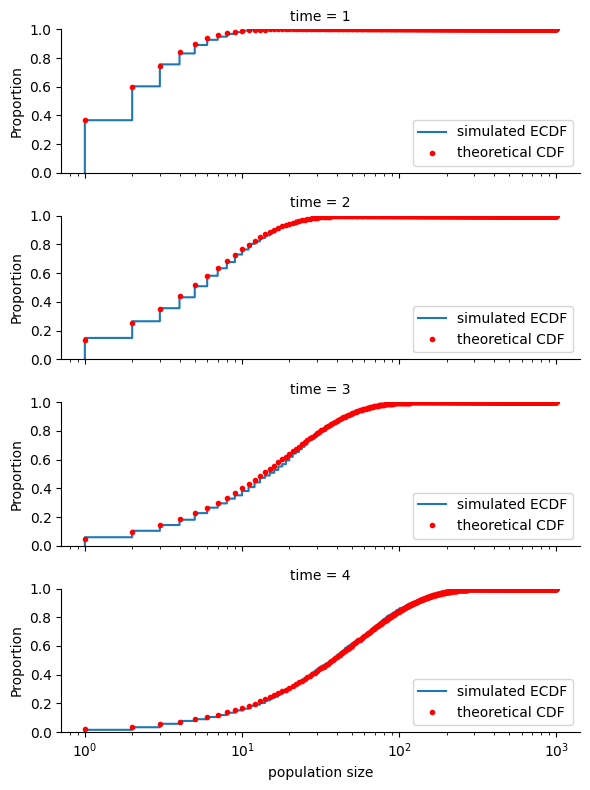

In [7]:
sns.displot(
    df,
    row="time",
    x="population size",
    aspect=3,
    height=2,
    log_scale=(True, False),
    kind="ecdf",
)
for sim_time, ax in zip(sim_times, plt.gcf().axes):
    ax.get_lines()[0].set_label("simulated ECDF")
    p = np.exp(-sim_time)
    ax.plot(
        scipy.stats.geom.cdf(range(1000), p),
        "r.",
        ds="steps-post",
        label="theoretical CDF",
    )
    ax.legend(loc="lower right")
plt.show()